# Stable diffusion based augmentation

In [1]:
%matplotlib widget
import torch
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image
from scipy.spatial.transform import Rotation as R
from transformers import SamModel, SamProcessor
import matplotlib.pyplot as plt
import os
import shutil
from tqdm import tqdm
import PIL
import numpy as np
from IPython.display import display
import utils

### Locate a face point

127


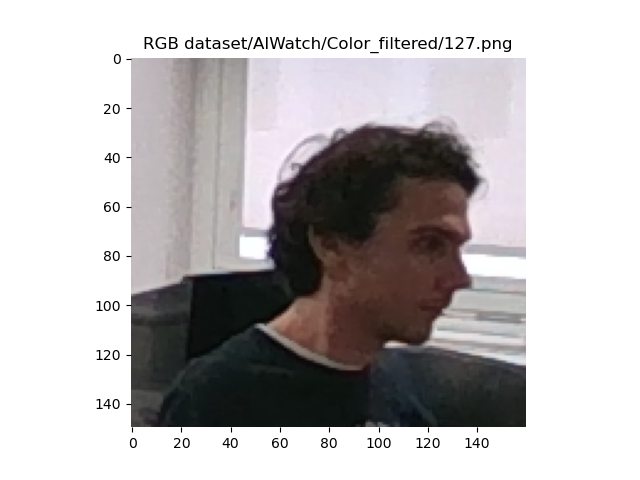

123.81818057964377 61.02585512631899
104.33766109912428 85.78234863281249
114.07792083938402 102.01611486657872
95.0032455147087 101.61027071073457


In [2]:
%matplotlib widget
points = []  # 2D location of a window in the image

def onclick(event):
    global points
    points.append([event.xdata, event.ydata])
    print(event.xdata, event.ydata)
    ax0.plot(event.xdata, event.ydata, 'ro', markersize=2)

def load_files():
    dataset_path = "dataset/AIWatch/Color_filtered/"
    image_paths = []
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".png"):
                rgb_image_path = os.path.join(root, file)
                image_paths.append(rgb_image_path)
    return image_paths

plt.figure(0).clear()
fig = plt.figure(0, figsize=(5, 5))
ax0 = fig.add_subplot(111, frameon=False)

image_paths = load_files()
image_path = image_paths[22]
sample_num = int(image_path.split("/")[-1].split(".")[0])
print(sample_num)

# Load the image with PIL
image = PIL.Image.open(image_path)

# Clear the previous plot
ax0.clear()

# Plot image
ax0.imshow(image)

# Plot title
ax0.set_title("RGB " + image_path)

# Connect the onclick event
fig.canvas.mpl_connect('button_press_event', onclick)

# Show the plot
plt.show()


### Use SAM to segment the face

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

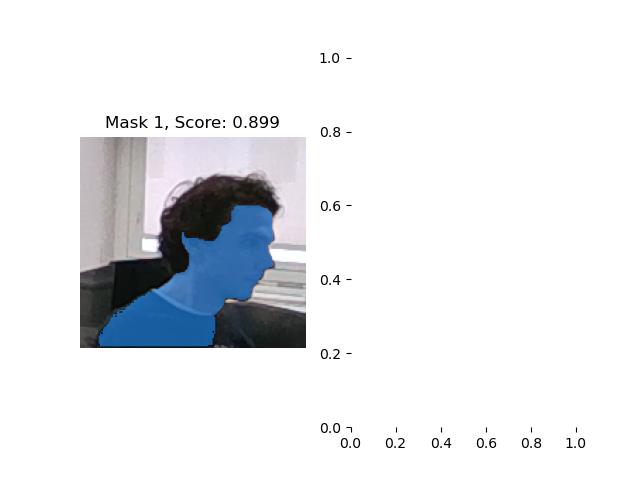

In [4]:
inputs = processor(image, input_points=[points], return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_masks_on_image(raw_image, masks, scores, figure=None):
  ax1.imshow(np.array(raw_image))
  show_mask(mask, ax1)
  ax1.title.set_text(f"Mask {1}, Score: {score.item():.3f}")
  ax1.axis("off")
  plt.show()

plt.figure(1).clear()
fig = plt.figure(1, figsize=(10, 5))
ax1 = fig.add_subplot(121, frameon=False)
ax2 = fig.add_subplot(122, frameon=False)

mask = masks[0]
if len(mask.shape) == 4:
  mask = mask.squeeze()
if scores.shape[0] == 1:
  score = scores.squeeze()
mask = mask[1]
mask = mask.cpu().detach()
score = score[1]

show_masks_on_image(image, mask, score)
show_mask(mask, ax2, random_color=False)

### Use stable diffusion inpainting

In [5]:
pipe = AutoPipelineForInpainting.from_pretrained("diffusers/stable-diffusion-xl-1.0-inpainting-0.1", torch_dtype=torch.float16, variant="fp16").to("cuda")
generator = torch.Generator(device="cuda").manual_seed(0)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


  0%|          | 0/49 [00:00<?, ?it/s]

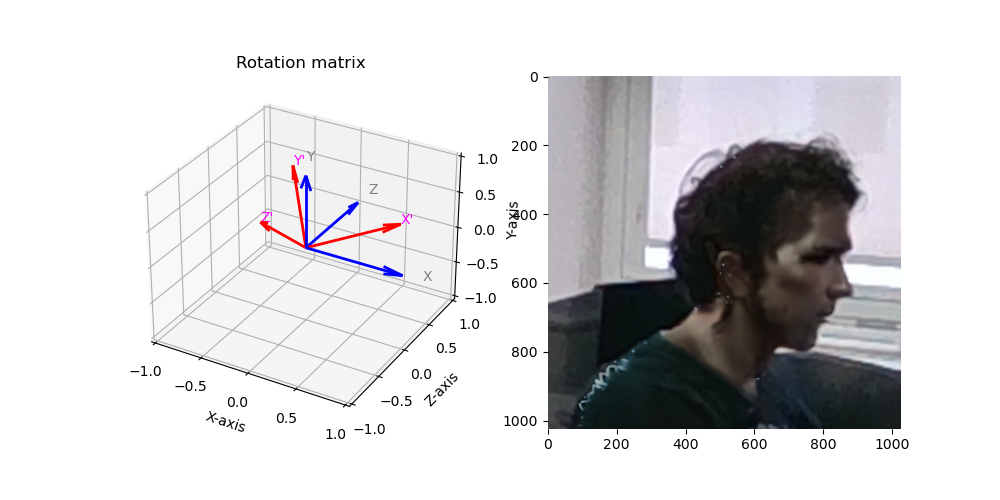

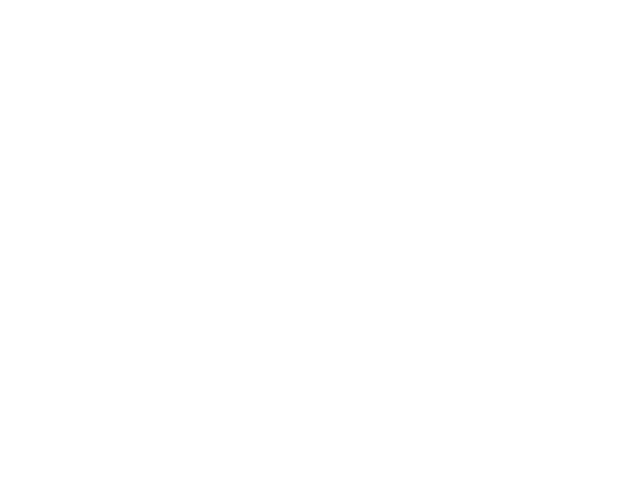

In [6]:
prompt = "the face of a woman"
prompt = "the face of a man"

masked_image = mask * 255
# convert tensor to PIL image
masked_image = PIL.Image.fromarray(masked_image.byte().cpu().numpy())

augmented_image = pipe(
  prompt=prompt,
  image=image,
  mask_image=masked_image,
  guidance_scale=1,
  num_inference_steps=50,
  strength=0.99,
  generator=generator,
).images[0]


plt.figure(3).clear()
fig = plt.figure(3, figsize=(10, 5))

sample_label_path = f"dataset/AIWatch/Angles/{str(sample_num)}.txt"
with open(sample_label_path) as f:
    angles = f.read().split(" ")
    angles = [float(angle) for angle in angles]
    label = torch.tensor(utils.convert_angles_from_AIWatch(angles))

rotation_matrix = R.from_euler('xzy', label, degrees=True).as_matrix()

#clear figure
plt.clf()
fig = plt.figure(2, figsize=(10, 5))
utils.plot_rotation_3D(fig, rotation_matrix)

ax2 = fig.add_subplot(122, frameon=False)
ax2.imshow(augmented_image)

plt.show()

### Save the augmented face to disk

In [ ]:
def retrieve_last_sample_num():
    files = os.listdir("dataset/AIWatch/Color_filtered/")
    max_num = 0
    for file in files:
        if file.endswith(".png"):
            num = int(file.split(".")[0])
            if num > max_num:
                max_num = num
    return max_num

new_sample_num = retrieve_last_sample_num() + 1

augmented_image.save(f"dataset/AIWatch/Color_filtered/{new_sample_num}.png")
shutil.copy(f"dataset/AIWatch/Angles/{str(sample_num)}.txt", f"dataset/AIWatch/Angles/{new_sample_num}.txt")
shutil.copy(f"dataset/AIWatch/Depth_filtered/{str(sample_num)}.png", f"dataset/AIWatch/Depth_filtered/{new_sample_num}.png")
shutil.copy(f"dataset/AIWatch/Depth_c_filtered/{str(sample_num)}.png", f"dataset/AIWatch/Depth_c_filtered/{new_sample_num}.png")